# Моделирование тяжести и последствий ДТП

## 1. Постановка задач

В этом разделе моделируются различные аспекты тяжести ДТП:

- Модель 1: предсказание числа погибших с использованием счётных регрессионных моделей
- Модель 2: классификация ДТП на случаи с погибшими и без
- Модель 3: оценка экономического ущерба от ДТП и факторов, его определяющих

Цель — понять, какие факторы влияют на последствия ДТП и как можно снизить тяжесть аварий с точки зрения смертности и ущерба.

---

## 2. Подготовка данных

- Загрузка необходимых библиотек
- Объединение таблиц `accidents`, `participants`, `vehicles`
- Фильтрация аварий с валидными значениями ключевых переменных
- Создание новых признаков:
  - `is_fatal` — бинарный индикатор наличия погибших
  - `log_cost` — логарифм экономического ущерба
- Разделение на тренировочную и тестовую выборки (например, 80/20)

In [5]:
# Загрузка библиотек и утилит
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import os
sys.path.append(os.path.abspath("../scripts")) # Добавляем путь к скриптам
from utils import (
    load_full_data_to_sqlite,
    run_query,
    save_png,
    save_html
)

# Пути для сохранения визуализаций
FIG_DIR = "../outputs/figures"
FIG_INT_DIR = "../outputs/figures/interactive"

### 2.1 Загрузка данных в SQLite

In [ ]:
accidents_url    = "https://disk.yandex.ru/d/yPdgwafR_2xElg"
participants_url = "https://disk.yandex.ru/d/YeyKLfXuETaEUQ"
vehicles_url     = "https://disk.yandex.ru/d/NJApFGWb85CWVQ"

conn = load_full_data_to_sqlite(
    accidents_url,
    participants_url,
    vehicles_url,
    db_path="../data/crash_database.db"
)

### 2.2 SQL-запрос с объединением таблиц

Для анализа факторов, влияющих на аварийность, разработан SQL-запрос, объединяющий данные из таблиц `accidents`, `participants` и `vehicles`. Основная цель — собрать релевантные переменные, исключив неинформативные или сложные для интерпретации данные, чтобы обеспечить чистоту и воспроизводимость анализа.

**Выбранные переменные**

- **Таблица `accidents`**:
  - `id`: уникальный идентификатор ДТП
  - `category`: тип ДТП
  - `datetime`: дата и время происшествия
  - `light`: состояние освещения
  - `participants_count`: количество участников
  - `dead_count`: количество погибших
  - `injured_count`: количество пострадавших
  - `weather`: погодные условия
- **Таблица `participants`**:
  - `accident_id`: ключ для связи с таблицей `accidents`
  - `role`: роль участника (водитель, пешеход и т.д.)
  - `gender`: пол участника
  - `violations`: нарушение ПДД
  - `years_of_driving_experience`: стаж вождения
- **Таблица `vehicles`**:
  - `year`: год производства ТС

**Переменные, исключённые из анализа**

Для повышения качества модели и упрощения интерпретации результатов исключены следующие данные:
- **Пространственные характеристики** (`region`, `county`, `longitude`, `latitude`): не входят в задачи проекта, так как фокус не на геоанализе.
- **Сложные текстовые переменные** (`nearby`, `road_conditions`, `participant_categories`): трудно интерпретировать из-за неоднозначности и отсутствия стандартизации.
- **Категориальные переменные с высокой кардинальностью** (`brand`, `vehicles.category`, `model`): большое число уникальных значений затрудняет их использование в моделировании.
- **Недостаточно документированные данные** (`severity`): отсутствие четкого определения "тяжести" ДТП в документации ГИБДД.
- **Последствия, а не причины** (`health_status`): зависят от самого ДТП и не могут использоваться как предикторы.
- **Технические артефакты**: лишние идентификаторы и служебные ключи, не участвующие в моделировании.

**Примечания**

- Запрос оптимизирован для отбора только релевантных признаков с целью снижения размерности и повышения читаемости модели.
- Исключение категориальных переменных с высокой кардинальностью и недокументированных данных повышает воспроизводимость и интерпретируемость результатов.

**Особые условия объединения**

Так как в одном ДТП может быть несколько участников (в том числе водителей), применена гибкая логика агрегации:
- Если в ДТП указан **один водитель-нарушитель** — анализ строится на его характеристиках.
- При нескольких **водителях-нарушителях** — признаки агрегируются (например, средний стаж, половой состав).
- При **отсутствии нарушителей (всего 1.2% ДТП)** — признаки агрегируются по всем водителям.

Признаки **агрегируются** на уровне ДТП таким образом, чтобы учесть состав участников и траснпортных средств без искажения выборки. Для отдельных переменных данные агрегируются следующим образом:

- Стаж вождения: среднее значение по выбранным водителям
- Пол: категориальный признак с тремя значениями: `all_male`, `all_female`, `mixed`
- Возраст транспортного средства: усреднённый по всем задействованным ТС, принадлежащих выбранным водителям. Возраст вычисляется как разница между годом ДТП `strftime('%Y', a.datetime)` и годом производства автомобиля `v.year`
- Наличие нарушителей-пешеходов: бинарный индикатор (true/false)

In [7]:
from utils import fetch_accident_features
df = fetch_accident_features(conn)

### 2.3 Фильтрация и генерация признаков

Для успешного моделирования и анализа данных о ДТП проведены преобразования переменных с целью улучшения качества моделей, уменьшения кардинальности и повышения интерпретируемости. Приведенные ниже преобразования способствуют учету важных факторов, влияющих на тяжесть ДТП, с сохранением логической связи с реальными условиями.

#### 1. Тип ДТП (category)
Переменная `category` имеет 18 уникальных значений, что создает избыточность для анализа, а также многие категории представлены малым числом наблюдений. Для уменьшения кардинальности объединены катигории "Наезд на стоящее ТС" и "Наезд на препятствие", а затем выбраны топ-5 категорий, составляющие более 93% всех ДТП. Оставшиеся категории объединены в категорию "Другой тип".

#### 2. Условия освещения (light)
Переменная `light` имеет 6 категорий, однако категория "не установлено" содержит лишь 68 наблюдений и была удалена. Также были объединены категории "В темное время суток, освещение отсутствует" и "В темное время суток, освещение не включено", поскольку они имеют схожие характеристики.

#### 3. Дата и время ДТП (datetime)
Переменная `datetime` играет важную роль, так как интенсивность движения изменяется в зависимости от времени суток и дня недели. Время имеет косвенное влияние на количество ДТП через другие факторы (например, внимание водителей).

##### Дата:
Для анализа была создана бинарная переменная, разделяющая дни на будние и выходные с целью сокрашения кардинальности

##### Время:
Для времени возможны два подхода кодирования:
- **Синусо-косинусная трансформация времени** (стандартный метод): преобразование в синусоидальные значения через формулы `sin(2π·hour/24)` и `cos(2π·hour/24)`
- **Категориальное разбиение времени на периоды**: дни разделяются на несколько категорий в зависимости от интенсивности движения, как показано в распределении ДТП

Был выбран **первый подход**. Хотя он теряет в интерпретируемости, но сокращает число переменных. Данные одномодальные, поэтому этот способ эффективен.

#### 4. Погода (weather)
Переменная `weather` содержит 97% значений с категориями "ясно", "пасмурно", "дождь", "снегопад". Остальные значения представляют редкие или смешанные состояния. Мы предполагаем, что "ясно" и "пасмурно" не сильно различаются по влиянию на аварийность, поэтому было принято решение разделить условия на **благоприятные** и **неблагоприятные**. 
- Неблагоприятные условия включают туман, дождь, снегопад, метель и ураганный ветер. Создана бинарная переменная, которая принимает значение 1, если в значении погоды присутствует хотя бы одно из перечисленных состояний, и 0 в противном случае.

#### 5. Пол (`drivers_gender`)
В переменной `drivers_gender` категория `mixed` включает всего 713 наблюдений (≈0.05%) выборки, что приводит к созданию избыточных и мультиколлинеарных dummy-переменных. Решение: удаление наблюдений с категорией `mixed` и преобразование переменной в бинарную `drivers_gender_female` (1 - все женщины, 0 - все мужчины).

#### 6. Количество погибших (dead_count) и летальность (lethality)
Переменная `dead_count` сохраняется в данных, а также добавляется бинарная переменная `lethality`, которая принимает значение 1, если в ДТП есть погибшие, и 0, если их нет.

#### 7. Создание переменной средний возраст транспортного средства `avg_vehicle_age`
Переменная `avg_vehicle_age` создается из переменной года ДТП `year` и года выпуска ТС `avg_vehicle_year`. Предварительно значения `avg_vehicle_year` до 1950 года приводятся к медианным, поскольку они создают выбросы и в ряде случаев представляют собой откровенные артефакты (год выпуска = 1)

#### 8. Обработка пропущенных значений и округление до целых чисел
Много пропущенных значений содержит переменная `avg_experience`. Пропущенные значения заменены на медианные для соответствующих переменных. Округление производится для `avg_experience` и `avg_vehicle_age`, поскольку представляются артефактом сбора данных

#### 9. Устранение выбросных значений
Переменная `avg_vehicle_age` содержит выбросные значения, которые могут внести шум в модели, поэтому были отсечены наблюдения с `avg_vehicle_age`>20

#### 10. Удаленные переменные
Переменные `driver_count` (число водителей) и `accident_id` были удалены,, так как являются техническими и не имеет значительного влияния на моделирование. Также удалены переменные, на основе которых были созданы новые.

In [8]:
# Создаем новый DataFrame df_processed для обработанных данных
df_processed = df.copy()

# 1. Преобразование переменной `category`
# Объединяем два вида наездов на неподвижные объекты и оставляем топ-5 категорий, остальные объединяем в 'Другой тип'
df_processed['category'] = df_processed['category'].replace(
    {"Наезд на препятствие": "Наезд", "Наезд на стоящее ТС": "Наезд"}
)
top_5_categories = df_processed['category'].value_counts().head(5).index
df_processed['category'] = df_processed['category'].apply(lambda x: x if x in top_5_categories else 'Другой тип')

# 2. Преобразование переменной `light`
# Удаляем категорию 'не установлено' и объединяем схожие категории
df_processed = df_processed[df_processed['light'] != 'не установлено']  # Удаляем 'не установлено'

df_processed['light'] = df_processed['light'].replace({
    'В темное время суток, освещение не включено': 'В темное время суток, освещение отсутствует'
})

# 3. Преобразование переменной `datetime`
# Проверяем формат datetime
df_processed['datetime'] = pd.to_datetime(df_processed['datetime'])

# 3.1. Дата: будни/выходные
df_processed['is_weekend'] = df_processed['datetime'].dt.weekday >= 5  # True (1) для выходных (сб, вс), False (0) для будней

# 3.2. Время: синусо-косинусная трансформация
df_processed['hour'] = df_processed['datetime'].dt.hour
df_processed['sin_time'] = np.sin(2 * np.pi * df_processed['hour'] / 24)
df_processed['cos_time'] = np.cos(2 * np.pi * df_processed['hour'] / 24)

# 4. Преобразование переменной `weather`
# Создаем бинарную переменную: 1 для неблагоприятных условий, 0 для благоприятных
adverse_conditions = ['дождь', 'снегопад', 'метель', 'ураганный ветер', 'туман']
df_processed['adverse_weather'] = df_processed['weather'].apply(
    lambda x: 1 if any(cond.lower() in str(x).lower() for cond in adverse_conditions) else 0
)

# 5. Преобразование `drivers_gender`
# Удаляем значения 'mixed' и преобразовываем в новую переменную с переименованием
df_processed = df_processed[df_processed['drivers_gender'] != 'mixed']
df_processed['drivers_gender_female'] = (df_processed['drivers_gender'] == 'all_female').astype(int)

# 5. Преобразование `dead_count` и создание `lethality`
# Оставляем dead_count как есть, добавляем бинарную переменную lethality
df_processed['lethality'] = df_processed['dead_count'].apply(lambda x: 1 if x > 0 else 0)

# 6. Создание переменной `avg_vehicle_age`
# Создаем переменную для года ДТП и приводим ее и 'avg_vehicle_year' к одному типу
df_processed['year'] = df_processed['datetime'].dt.year
df_processed[['year', 'avg_vehicle_year']] = df_processed[['year', 'avg_vehicle_year']].astype(float)

# Заменяем пропущенные значения и значения < 1950 на медиану
df_processed['avg_vehicle_year'] = df_processed['avg_vehicle_year'].fillna(df_processed['avg_vehicle_year'].median())

# Вычисляем медианы для столбца avg_vehicle_year отдельно
median_year = df_processed['avg_vehicle_year'].median()

# Заменияем значения < 1950 на медиану
df_processed.loc[df_processed['avg_vehicle_year'] < 1950, 'avg_vehicle_year'] = median_year

# Создаём переменную возраста ТС
df_processed['avg_vehicle_age'] = df_processed['year'] - df_processed['avg_vehicle_year']

# 7. Замена пропусков медианой и округление до целых
df_processed['avg_experience'] = df_processed['avg_experience'].fillna(df_processed['avg_experience'].median())
df_processed['avg_experience'] = df_processed['avg_experience'].round(0).astype(int)
df_processed['avg_vehicle_age'] = df_processed['avg_vehicle_age'].round(0).astype(int)

# 8. Удаление технических и необработанных переменных
df_processed = df_processed.drop(columns=['driver_count', 'accident_id', 'datetime', 'hour', 'year', 'avg_vehicle_year', 'weather', 'drivers_gender'])

# 9. Преобразование булевых переменных в числовые
df_processed['is_weekend'] = df_processed['is_weekend'].astype(int)

#### Проверка целостности данных

После обработки данных в `df_processed` пропущенные значения отсутствуют

## 3. Модель 1: Счётные модели для предсказания числа погибших

### 3.1. Обоснование выбора модели

Целью модели является предсказание числа погибших, так как основным приоритетом в политике по снижению аварийности является минимизация числа смертельных случаев. Число погибших является **дискретной счётной переменной** (`dead_count ∈ {0,1,2,...}`) с преобладанием нулевых значений, что делает её подходящей для применения **счётных моделей** — пуассоновской и негативной биномиальной регрессий.

Такие модели являются стандартным инструментом в академических и прикладных исследованиях по дорожной безопасности. Они обеспечивают интерпретируемые коэффициенты и позволяют количественно оценивать влияние различных факторов на число погибших.

Мы протестировали следующие модели из семейства счётных:

- **Пуассоновская регрессия (Poisson regression)** — базовая модель, предполагающая равенство дисперсии и среднего.
- **Негативная биномиальная регрессия (Negative Binomial regression)** — обобщение пуассоновской модели, допускающее overdispersion.

Первоначально были протестированы также **Zero-Inflated** модификации моделей (ZIP и ZINB) с различными комбинациями временных признаков. Однако на практике они показали крайнюю нестабильность: модели не сходились, генерировали бесконечные значения функции потерь и не выдавали интерпретируемых коэффициентов. Это согласуется с известными ограничениями реализации ZINB в `statsmodels`.

Таким образом, итоговое сравнение производилось между **Negative Binomial** и **Poisson** моделями.

Подробности по методам см. в [Road Crash Prediction Models: Different Statistical Modeling Approaches](https://doi.org/10.4236/jtts.2017.72014).

Для выбора подходящей модели рассчитаны среднее и дисперсия `remainder__dead_count`.

In [28]:
# Расчет среднего и дисперсии для dead_count

mean_dead_count = df_processed["dead_count"].mean()
variance_dead_count = df_processed["dead_count"].var()

#### Выбор модели
- Дисперсия `remainder__dead_count` (0.15) превышает среднее значение (0.11), что указывает на наличие **overdispersion**. Поэтому в качестве основной выбрана **Negative Binomial** модель.
- Модель Poisson использована для сравнения: обе модели обучались на одинаковом наборе переменных, включающем временные, погодные, категориальные и количественные характеристики ДТП.

### 3.2. Подготовка данных

#### Обработка категориальных переменных

Для дальнейшего анализа необходимо преобразовать категориальные переменные в числовые:

- Выбран метод **One-hot encoding** (для каждой категории создается отдельная бинарная переменная) с удалением переменной базового (референсного) уровня, что помогает избежать мультиколлинеарности. Такой подход позволяет сохранить интерпретируемость модели.
- Создается `df_regression` при помощи библиотеки **`sklearn`**
- Референсный уровень выбирается вручную для наглялности интерпретации 


In [31]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

# Спискок категориальных переменных
categorical_columns = ['category', 'light']

# Выбор референсных уровней
drop_categories = {
    'category': 'Другой тип',  
    'light': 'Не установлено'
}

# Настройка ColumnTransformer с полным кодированием
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(sparse_output=False), categorical_columns)
    ],
    remainder='passthrough'  # Сохранение числовых и бинарных столбцов
)

# Применение трансформации
df_regression = pd.DataFrame(
    preprocessor.fit_transform(df_processed),
    columns=preprocessor.get_feature_names_out()
)

# Ручное удаление выбранных категорий
for col, drop_cat in drop_categories.items():
    drop_col = f'cat__{col}_{drop_cat}'
    if drop_col in df_regression.columns:
        df_regression = df_regression.drop(columns=[drop_col])
    else:
        print(f"Предупреждение: {drop_col} не найдена в закодированных столбцах!")

# Приводим все необходимые колонки к числовому типу
df_regression = df_regression.apply(lambda col: pd.to_numeric(col, errors='coerce'))

# Удаляем лишние
df_regression = df_regression.drop(columns=df_regression.select_dtypes(include='object').columns)

df_regression = df_regression.drop(columns=[
    'remainder__lethality',
    'remainder__injured_count'
])

#### Описание переменных

##### Зависимая переменная
- `remainder__dead_count`: Число погибших в ДТП (дискретная счётная переменная).

##### Предикторы
- **Категориальные переменные (закодированы через One-Hot Encoding с ручным удалением референсных уровней):**
  - `cat__category_*`:
    - `cat__category_Наезд на пешехода`: 1, если ДТП связано с наездом на пешехода, 0 — иначе.
    - `cat__category_Наезд`: 1, если ДТП связано с наездом на неподвижный объект, 0 — иначе.
    - `cat__category_Опрокидывание`: 1, если ДТП связано с опрокидыванием, 0 — иначе.
    - `cat__category_Столкновение`: 1, если ДТП связано со столкновением, 0 — иначе.
    - `cat__category_Съезд с дороги`: 1, если ДТП связано со съездом с дороги, 0 — иначе.
    - *Референсный уровень*: `cat__category_Другой тип` (удалён).
  - `cat__light_*`:
    - `cat__light_В темное время суток, освещение включено`: 1, если ДТП произошло в тёмное время суток с включённым освещением, 0 — иначе.
    - `cat__light_В темное время суток, освещение отсутствует`: 1, если ДТП произошло в тёмное время суток без освещения, 0 — иначе.
    - `cat__light_Светлое время суток`: 1, если ДТП произошло в светлое время суток, 0 — иначе.
    - `cat__light_Сумерки`: 1, если ДТП произошло в сумерках, 0 — иначе.
    - *Референсный уровень*: `cat__light_Не установлено` (удалён).
  - `cat__time_period_*`:
    - `cat__time_period_вечерний час пик`: 1, если ДТП произошло в вечерний час пик, 0 — иначе.
    - `cat__time_period_дневная активность`: 1, если ДТП произошло в период дневной активности, 0 — иначе.
    - `cat__time_period_утренний час пик`: 1, если ДТП произошло в утренний час пик, 0 — иначе.
    - *Референсный уровень*: `cat__time_period_ночной спад` (удалён).

- **Числовые и бинарные переменные:**
  - `remainder__accident_id`: Уникальный идентификатор ДТП (числовой).
  - `remainder__avg_experience`: Средний стаж водителей (числовой).
  - `remainder__avg_vehicle_age`: Средний возраст транспортных средств (числовой).
  - `remainder__has_violating_pedestrian`: 1, если в ДТП участвовал нарушающий правила пешеход, 0 — иначе.
  - `remainder__is_weekend`: 1, если ДТП произошло в выходной день, 0 — иначе.
  - `remainder__sin_time`: Синус времени суток (циклическое представление времени, числовой).
  - `remainder__cos_time`: Косинус времени суток (циклическое представление времени, числовой).
  - `remainder__adverse_weather`: 1, если погодные условия неблагоприятные, 0 — иначе.
  - `remainder__drivers_gender_female`: 1, если все виновные водители — женщины, 0 — мужчины.
  - `remainder__participants_count`: Число участников ДТП (числовой, используется как переменная экспозиции).
 
#### Проверка на мультиколлинеарность

Корреляция между признаками была проверена — признаков с высокой корреляцией не выявлено.

In [33]:
# Корреляция между предикторами
df_num = df_regression.select_dtypes(include=['float', 'int'])
corr = df_num.corr().abs()
high_corr = corr.where(np.triu(np.ones(corr.shape), k=1).astype(bool))
high_corr_pairs = high_corr.stack()[high_corr.stack() > 0.95]

### 3.3. Обучение моделей

#### Инструменты

Для реализации моделей использовалась библиотека **`statsmodels`**, которая поддерживает как стандартные счётные модели (`Poisson`, `NegativeBinomial`), так и их zero-inflated варианты. Однако из-за нестабильности последних в нашем случае выбор был сделан в пользу стандартных моделей.

#### Этапы

1. **Негативная биномиальная** модель обучена на полном наборе предикторов.  
2. **Пуассоновская** модель обучена на том же наборе для сравнения.  
3. Для обеих моделей рассчитаны значения MSE, значимые переменные и интерпретируемые коэффициенты.  

In [35]:
from utils import (
    PREDICTORS, TARGET, EXPOSURE,
    prepare_train_test,
    fit_negative_binomial, fit_poisson,
    evaluate_mse,
    coef_table,
    plot_significant_coefs
)

# 1. Сплит
X_tr, X_te, y_tr, y_te, exp_tr, exp_te = prepare_train_test(df_regression)

# 2. NB-модель
nb_res = fit_negative_binomial(X_tr, y_tr, exp_tr)
mse_nb = evaluate_mse(nb_res, X_te, y_te, exp_te)
coef_nb = coef_table(nb_res, drop_vars=['const','alpha'])

# 3. Poisson
po_res = fit_poisson(X_tr, y_tr, exp_tr)
mse_po = evaluate_mse(po_res, X_te, y_te, exp_te)
coef_po = coef_table(po_res, drop_vars=['const'])

# 4. Вывод результатов
print(f"NB MSE: {mse_nb:.4f}")
display(coef_nb)

print(f"Poisson MSE: {mse_po:.4f}")
display(coef_po)

NB MSE: 0.1398


,Variable,Coefficient,P-value,Significant (p<0.05)
0,remainder__adverse_weather,0.116,0.0000,True
1,remainder__cos_time,0.204,0.0000,True
2,remainder__sin_time,0.135,0.0000,True
3,cat__category_Съезд с дороги,0.916,0.0000,True
4,cat__category_Опрокидывание,1.004,0.0000,True
5,cat__category_Наезд,0.788,0.0000,True
6,cat__category_Наезд на пешехода,0.159,0.0000,True
7,remainder__avg_experience,0.007,0.0000,True
8,cat__category_Столкновение,0.375,0.0000,True
9,remainder__drivers_gender_female,-0.516,0.0000,True


Poisson MSE: 0.1394


,Variable,Coefficient,P-value,Significant (p<0.05)
0,remainder__adverse_weather,0.100,0.0000,True
1,remainder__cos_time,0.207,0.0000,True
2,remainder__sin_time,0.135,0.0000,True
3,cat__category_Съезд с дороги,0.845,0.0000,True
4,cat__category_Опрокидывание,0.938,0.0000,True
5,cat__category_Наезд,0.743,0.0000,True
6,cat__category_Наезд на пешехода,0.158,0.0000,True
7,remainder__avg_experience,0.007,0.0000,True
8,cat__category_Столкновение,0.388,0.0000,True
9,cat__light_Светлое время суток,-1.049,0.0000,True


### 3.4 Сравнение моделей и интерпретация

#### Сравнение моделей

- Обе модели показали сопоставимую метрику качества (MSE):  
  - **Negative Binomial**: `MSE = 0.1398`  
  - **Poisson**: `MSE = 0.1394`
- Обе модели выявили одинаковый набор **значимых переменных**, и коэффициенты оказались сопоставимы по знакам и величинам.

Таким образом, обе модели подтверждают результаты друг друга, но **Negative Binomial** остаётся предпочтительной, учитывая теоретически обоснованную избыточную дисперсию и устойчивость к счётным данным с большим числом нулей.

#### Интерпретация результатов

Модель негативной биномиальной регрессии показала хорошее качество предсказания:  
**Mean Squared Error (MSE): 0.1398**, что сопоставимо с результатами пуассоновской модели и подтверждает стабильность предсказаний.

Модель выявила **широкий спектр значимых факторов**, влияющих на число погибших в ДТП.

##### Вступление:

Коэффициенты негативной биномиальной регрессии интерпретируются в логарифмической шкале: модель оценивает логарифм ожидаемого числа погибших в зависимости от признаков.

Чтобы получить интерпретируемую величину, коэффициенты обычно **экспоненцируются** (`exp(β)`), что позволяет выразить результат в виде **относительного изменения**: во сколько раз увеличивается (или уменьшается) ожидаемое число погибших при изменении признака на единицу.

Например:
- коэффициент `β = 0.69` → `exp(0.69) ≈ 2.0` означает удвоение риска;
- `β = -1.10` → `exp(-1.10) ≈ 0.33` означает снижение до одной трети.

Таким образом, в интерпретации ниже мы указываем как знак коэффициента, так и его эффект в долях или кратности.

##### Основные выводы:

- **Виды ДТП с высокой смертностью**:
  - `cat__category_Опрокидывание` (коэфф. 1.004, exp(β) ≈ ×2.73)  
    → ДТП с опрокидыванием наиболее опасные и увеличивают ожидаемое число погибших в **2.7 раз**.
  - `cat__category_Съезд с дороги` (0.916 → ×2.50)
  - `cat__category_Наезд` (0.788 → ×2.20)
  - `cat__category_Столкновение` (0.375 → ×1.45)
  - `cat__category_Наезд на пешехода` (0.159 → ×1.17)  
    → Эти типы аварий статистически значимо увеличивают риск летального исхода по сравнению с остальными категориями ДТП.

- **Освещение**:
  - `cat__light_В темное время суток, освещение включено` (−1.244 → ×0.29)  
    → Аварии **в тёмное время суток с освещением** связаны с наименьшим риском — риск погибших **уменьшается почти в 3.5 раза**. Вероятно, это отражает повышенную осторожность водителей в таких условиях.
  - `cat__light_Светлое время суток` (−1.013 → ×0.36)
  - `cat__light_Сумерки` (−0.764 → ×0.47)
    → Самая высокая аварийность из статистически значимых факторов.
  - `cat__light_В темное время суток, освещение отсутствует` (−0.245 → ×0.78, `p = 0.41`)  
    → Эффект не является статистически значимым, но демонстрирует наиболее высокую аварийность.

- **Поведенческие и социальные факторы**:
  - `remainder__has_violating_pedestrian` (0.970 → ×2.64)  
    → Наличие нарушающего пешехода — **один из самых сильных предикторов**: увеличивает ожидаемое число погибших в **2.6 раза**.
  - `remainder__is_weekend` (0.110 → ×1.12)  
    → ДТП, произошедшие в выходные, связаны с **ростом смертности на 12%**.
  - `remainder__adverse_weather` (0.116 → ×1.12)  
    → Неблагоприятные погодные условия увеличивают ожидаемое число погибших примерно на **12%**.
  - `remainder__drivers_gender_female` (−0.516 → ×0.60)  
    → Если все виновные водители — женщины, риск смертности **уменьшается на 40%**, что может отражать отличия в стиле вождения.
  - `remainder__avg_experience` (0.007 → ×1.01, `p < 0.001`)  
    → Более высокий средний стаж водителей статистически значимо связан с **небольшим увеличением числа погибших**. Возможно, в действительности существует **нелинейная зависимость** — рост после первых лет вождения в связи с потерей осторожности и снижение у очень опытных водителей.

- **Временные признаки**:
  - `remainder__sin_time` (0.135 → ×1.14)  
  - `remainder__cos_time` (0.204 → ×1.23)  
    → Циклические признаки времени суток оказались статистически значимыми. Это указывает на **существенную суточную динамику** смертности, связанную с часами повышенного риска.

- **Технические характеристики**:
  - `remainder__avg_vehicle_age` (0.010 → ×1.01)  
    → Каждые дополнительные 1 год возраста автомобиля **увеличивают ожидаемое число погибших примерно на 1%**.

##### Дисперсия

- Параметр `alpha = 1.065` подтверждает наличие **сверхдиперсии**, что оправдывает применение негативной биномиальной регрессии вместо пуассоновской.

#### Визуализация результатов

In [37]:
plot_path = os.path.join(FIG_DIR, "significant_coeffs_nb.png")
plot_significant_coefs(coef_nb, plot_path)

#### Вывод

Модель выявила значимые и интерпретируемые закономерности, отражающие как технические, так и поведенческие аспекты смертности в ДТП. Эти результаты могут использоваться как для построения предсказательных моделей, так и для разработки рекомендаций в области транспортной безопасности.

#### Дальнейшие шаги

На следующем этапе анализ будет разделён по типу целевой переменной:

- Для задачи классификации ("есть погибшие / нет") будут применяться модели бинарной классификации: **дерево решений** — для интерпретируемости, а также **случайный лес**. Это должно увеличить предсказательную способность.

- Для оценки **экономического ущерба от ДТП** планируется использовать **линейную регрессию с регуляризацией** (Lasso, Ridge), что подходит для анализа эффективности принимаемых мер в БДД.

## 4. Модель 2: Деревья решений и случайный лес

### 4.1. Подготовка данных

Для деревьев решений и случайного леса будут использованы идентичные данные, поскольку базовые алгоритмы в этих методах совпадают.

#### Обработка категориальных переменных

Для дальнейшего анализа необходимо преобразовать категориальные переменные в числовые:

- Выбран метод **One-hot encoding** (для каждой категории создается отдельная бинарная переменная) без удаления базового уровня, поскольку эти алгоритмы не сталкиваются с проблемой мультиколлинеарности.
- Был рассмотрен метод **Target encoding**, однако он не дает ощутимых преимуществ для переменных с невысокой кардинальностью, но усложняет интерпретацию.
- Создается `df_classification` при помощи библиотеки **`sklearn`** 

In [9]:
import pandas as pd
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

# Список категориальных переменных
categorical_columns = ['category', 'light']

# Настройка ColumnTransformer для one-hot encoding всех категорий
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(sparse_output=False), categorical_columns)
    ],
    remainder='passthrough'  # Сохранение числовых и бинарных столбцов
)

# Применение трансформации к данным
df_classification = pd.DataFrame(
    preprocessor.fit_transform(df_processed),
    columns=preprocessor.get_feature_names_out()
)

# Приведение всех столбцов к числовому типу
df_classification = df_classification.apply(lambda col: pd.to_numeric(col, errors='coerce'))

# Удаление лишних столбцов
df_classification = df_classification.drop(columns=df_classification.select_dtypes(include='object').columns)

df_classification = df_classification.drop(columns=[
    'remainder__dead_count',
    'remainder__injured_count'
])

### 4.2. Дерево решений

- Для предсказания смертельных исходов в ДТП была построена модель на основе дерева решений. Чтобы учесть несбалансированность данных, где случаи с погибшими составляют малую долю (менее 10% записей), использован параметр `class_weight='balanced'`. Это позволило модели лучше обучаться предсказывать редкий класс (ДТП с погибшими), присваивая ему больший вес при разбиении узлов.

- Для оценки качества модели применялась метрика **F1-score**, которая балансирует между точностью (precision) и полнотой (recall). F1-score была выбрана, так как она эффективно отражает производительность модели на несбалансированном датасете, уделяя внимание правильному предсказанию редкого класса.

- Введено ограничение на глубину `max_depth=10`, чтобы избежать переобучения

#### Обучение модели

Был применен ``GridSearchCV`` для подбора параметров (`max_depth`, `min_samples_leaf`, `min_samples_split`), однако это не привело к существенному улучшению качества модели. Модель с наилучшими параметрами (`max_depth=10`, `min_samples_leaf=20`, `min_samples_split=2`) представлена ниже.

In [10]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import f1_score, roc_auc_score, average_precision_score, classification_report, plot_tree

# Список переменных
columns = [
    'cat__category_Другой тип', 'cat__category_Наезд',
    'cat__category_Наезд на пешехода', 'cat__category_Опрокидывание',
    'cat__category_Столкновение', 'cat__category_Съезд с дороги',
    'cat__light_В темное время суток, освещение включено',
    'cat__light_В темное время суток, освещение отсутствует',
    'cat__light_Не установлено', 'cat__light_Светлое время суток',
    'cat__light_Сумерки', 'remainder__participants_count',
    'remainder__avg_experience', 'remainder__has_violating_pedestrian',
    'remainder__is_weekend', 'remainder__sin_time', 'remainder__cos_time',
    'remainder__adverse_weather', 'remainder__drivers_gender_female',
    'remainder__lethality', 'remainder__avg_vehicle_age'
]

# Признаки и целевая переменная
features = [col for col in columns if col != 'remainder__lethality']
target = 'remainder__lethality'

# Разбиение данных (80/20)
X = df_classification[features]
y = df_classification[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Обучение с лучшими параметрами
dt = DecisionTreeClassifier(max_depth=10, min_samples_leaf=20, min_samples_split=2, class_weight='balanced', random_state=42)
dt.fit(X_train, y_train)

# Предсказания
y_pred = dt.predict(X_test)
y_pred_proba = dt.predict_proba(X_test)[:, 1]

# Метрики
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)
pr_auc = average_precision_score(y_test, y_pred_proba)

# Classification Report в словарь
report = classification_report(y_test, y_pred, target_names=['Без погибших', 'С погибшими'], output_dict=True)

# Создание таблицы с результатами
results_table = pd.DataFrame({
    'Метрика': ['F1-score (тест)', 'ROC-AUC', 'PR-AUC', 
                'Precision (Без погибших)', 'Recall (Без погибших)', 'F1-score (Без погибших)',
                'Precision (С погибшими)', 'Recall (С погибшими)', 'F1-score (С погибшими)'],
    'Значение': [f1, roc_auc, pr_auc,
                 report['Без погибших']['precision'], report['Без погибших']['recall'], report['Без погибших']['f1-score'],
                 report['С погибшими']['precision'], report['С погибшими']['recall'], report['С погибшими']['f1-score']]
}).round(4)

# Отображение таблицы в Jupyter
display(results_table.style.set_caption('Результаты дерева решений').set_table_styles([
    {'selector': 'caption', 'props': [('font-size', '16px'), ('font-weight', 'bold')]}
]))

# Важность признаков в таблице
feature_importance = pd.DataFrame({
    'Признак': features,
    'Важность': dt.feature_importances_
}).sort_values(by='Важность', ascending=False).round(4)
display(feature_importance.style.set_caption('Важность признаков').set_table_styles([
    {'selector': 'caption', 'props': [('font-size', '16px'), ('font-weight', 'bold')]}
]))

,Метрика,Значение
0,F1-score (тест),0.286600
1,ROC-AUC,0.712200
2,PR-AUC,0.241400
3,Precision (Без погибших),0.945200
4,Recall (Без погибших),0.724400
5,F1-score (Без погибших),0.820200
6,Precision (С погибшими),0.188000
7,Recall (С погибшими),0.603200
8,F1-score (С погибшими),0.286600


,Признак,Важность
7,"cat__light_В темное время суток, освещение отсутствует",0.413300
11,remainder__participants_count,0.209500
13,remainder__has_violating_pedestrian,0.099800
18,remainder__drivers_gender_female,0.057900
3,cat__category_Опрокидывание,0.033800
5,cat__category_Съезд с дороги,0.030800
9,cat__light_Светлое время суток,0.027300
1,cat__category_Наезд,0.024900
15,remainder__sin_time,0.018900
12,remainder__avg_experience,0.018600


#### Интерпретация результатов

Классификация ДТП на ДТП с погибшими и без погибших дала следующие результаты:

- F1-score (тест): 0.29 — низкое обобщающее качество модели.
- ROC-AUC: 0.71 — модель способна различать классы, но неустойчива.
- PR-AUC: 0.24 — слабое качество приоритетной задачи (предсказание погибших).

Для класса с погибшими:

- Precision: 0.19
- Recall: 0.60
- F1-score: 0.29

Модель находит часть ДТП с погибшими, но делает это неточно: много ложноположительных. Для класса без погибших метрики выше (`F1 = 0.80`), что ожидаемо при сильном дисбалансе классов.

**Важнейшие признаки**:
- Освещение: "тёмное время суток, освещения нет" (0.41) — наиболее важный фактор в противовес счётной модели, где он был незначим, вопреки теоретическим ожиданиям.
- Число участников в ДТП (0.21) — как экспозиция.
- Наличие нарушителя-пешехода (0.10) — совпадает с влиянием фактора с счетной модели.

#### Визуализация важности признаков

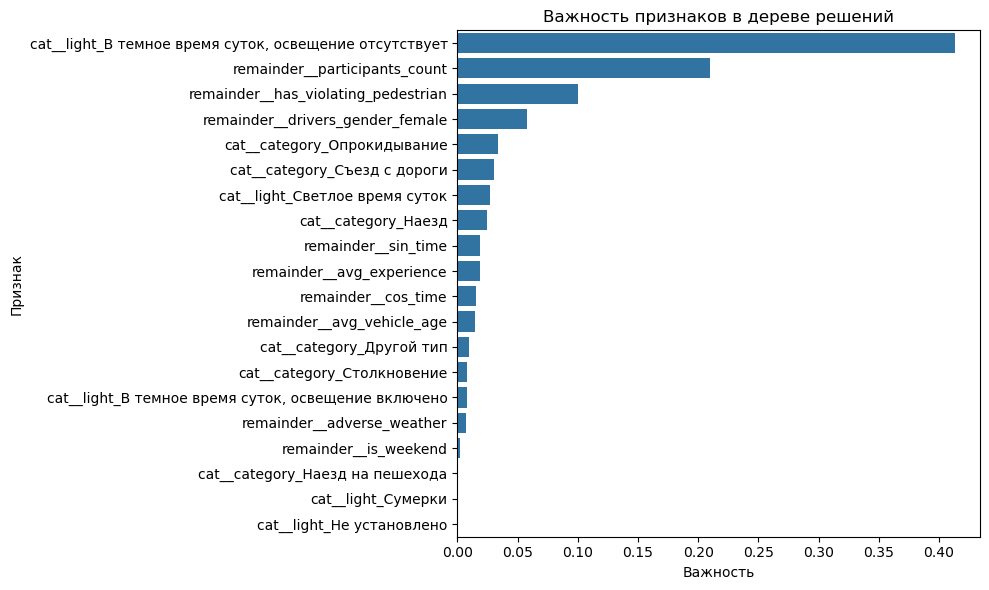

In [16]:
plt.figure(figsize=(10, 6))
sns.barplot(x=feature_importance['Важность'], y=feature_importance['Признак'])
plt.title('Важность признаков в дереве решений')
plt.xlabel('Важность')
plt.tight_layout()
plt.savefig(f"{FIG_DIR}/tree_feature_importance.png")
plt.show()

## Работа в процессе
### 4.3. Случайный лес